In [1]:
from src.SensitivityAnalysis import load_data
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [70]:
data = load_data()
averaged = []
for i in range(len(data) // 10 - 1):
    averaged.append(data['Gini'].iloc[i*10:(i+1)*10].mean())
averaged = np.array(averaged)

In [62]:
# Find where gini maximized
worst = dict(data.iloc[data['Gini'].idxmax()])
best = dict(data.iloc[data['Gini'].idxmin()])

worst = {key: float(value) for (key,value) in worst.items()}
best = {key: float(value) for (key,value) in best.items()}

print(worst)
print(best)


{'vision_mean': 1.760488254018128, 'metabolism_mean': 8.916313346475363, 'max_age_mean': 93.93653666600584, 'repopulate_factor': 12.950524846091866, 'cell_regeneration': 3.6728568486869335, 'Gini': 0.6713892971328177, 'Trader Count': 31.0}
{'vision_mean': 2.373409377411008, 'metabolism_mean': 8.753417870029807, 'max_age_mean': 73.68213335052133, 'repopulate_factor': 12.527411002665758, 'cell_regeneration': 1.769727412611246, 'Gini': 0.0, 'Trader Count': 1.0}


In [71]:
# Find closest to average
dist = (averaged - np.mean(averaged))**2
idx = np.argmin(dist)

typical = dict(data.iloc[idx * 10])
typical = {key: float(value) for (key,value) in typical.items()}

print(typical)

{'vision_mean': 5.089661035686731, 'metabolism_mean': 5.488567331805825, 'max_age_mean': 74.16665683500469, 'repopulate_factor': 8.643216881901026, 'cell_regeneration': 3.368525765836239, 'Gini': 0.4208614415738996, 'Trader Count': 1428.0}


In [2]:
from src.SugarScape import SugarScape
from mesa import batch_run
import numpy as np
from tqdm import tqdm

map_scheme = 'uniform'

scenarios = [
    {'vision_mean': 1.760488254018128, 'metabolism_mean': 8.916313346475363, 'max_age_mean': 93.93653666600584,
     'repopulate_factor': 12.950524846091866, 'cell_regeneration': 3.6728568486869335, 'map_scheme': map_scheme},  # Worst case
    
    {'vision_mean': 2.373409377411008, 'metabolism_mean': 8.753417870029807, 'max_age_mean': 73.68213335052133,
     'repopulate_factor': 12.527411002665758, 'cell_regeneration': 1.769727412611246, 'map_scheme': map_scheme},   # Best case
    
    {'vision_mean': 5.089661035686731, 'metabolism_mean': 5.488567331805825, 'max_age_mean': 74.16665683500469,
     'repopulate_factor': 8.643216881901026, 'cell_regeneration': 3.368525765836239, 'map_scheme': map_scheme},    # Average case
    
    {'vision_mean': 6, 'metabolism_mean': 3, 'max_age_mean': 74.16665683500469,
     'repopulate_factor': 8.643216881901026, 'cell_regeneration': 3.368525765836239, 'map_scheme': map_scheme},    # Well optimized case
    
    {'vision_mean': 1, 'metabolism_mean': 9, 'max_age_mean': 74.16665683500469,
     'repopulate_factor': 8.643216881901026, 'cell_regeneration': 3.368525765836239, 'map_scheme': map_scheme},    # Poorly optimized case
    
    {'vision_mean': 3.5, 'metabolism_mean': 6, 'max_age_mean': 85,
     'repopulate_factor': 10, 'cell_regeneration': 3, 'map_scheme': map_scheme},                                   # Balanced case
    
    {'vision_mean': 5.089661035686731, 'metabolism_mean': 5.488567331805825, 'max_age_mean': 100,
     'repopulate_factor': 15, 'cell_regeneration': 3.368525765836239, 'map_scheme': map_scheme},                  # Slow evolving
    
    {'vision_mean': 5.089661035686731, 'metabolism_mean': 5.488567331805825, 'max_age_mean': 70,
     'repopulate_factor': 5, 'cell_regeneration': 3.368525765836239, 'map_scheme': map_scheme},                    # Fast evolving
    
]

results = []
replicates = 10
max_steps = 200
for scenario in scenarios:
    batch = batch_run(SugarScape, scenario, number_processes=None,
                      iterations=replicates, max_steps=max_steps, display_progress=True, data_collection_period=1)
    for i in range(replicates):
        scenario["Gini"] = [val['Gini'] for val in batch[(max_steps+1)*i:(max_steps+1)*(i+1)]]
        scenario["Trader Count"] = [val['Trader Count'] for val in batch[(max_steps+1)*i:(max_steps+1)*(i+1)]]

        results.append(list(scenario.values()))

names = list(scenario.keys()) 
df = pd.DataFrame(results, columns=names)
df.to_csv(f'Base_results_{map_scheme}.csv')


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

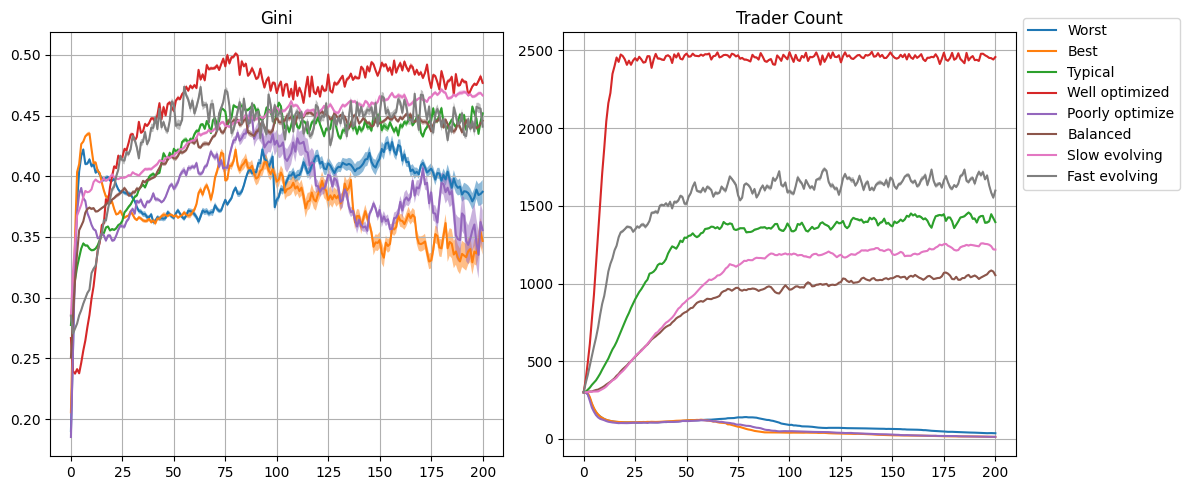

In [3]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
names = ['Worst', 'Best', 'Typical', 'Well optimized', 'Poorly optimize', 'Balanced', 'Slow evolving', 'Fast evolving']
for i in range(len(scenarios)):
    # Get gini and trader count of every scenario
    gini = df.iloc[i*10:(i+1)*10]['Gini']
    trader = df.iloc[i*10:(i+1)*10]['Trader Count']
    
    # Convert to 2d np arrays
    gini = np.vstack(gini)
    trader = np.vstack(trader)
    
    # Get means and ci
    gini_mean = np.mean(gini, axis=0)
    gini_ci = np.std(gini, ddof=1, axis=0) / replicates
    trader_mean = np.mean(trader, axis=0)
    trader_ci = np.std(trader, ddof=1, axis=0) / replicates
    
    # Plotting
    x = np.arange(len(gini_mean))
    ax[0].plot(x, gini_mean, label=names[i])
    ax[0].fill_between(x, gini_mean + gini_ci, gini_mean - gini_ci, alpha=0.5)
    ax[1].plot(x, trader_mean, label=names[i])
    ax[1].fill_between(x, trader_mean + trader_ci, trader_mean - trader_ci, alpha=0.5)

ax[1].legend(bbox_to_anchor=(1, 1.05))
ax[0].set_title('Gini')
ax[1].set_title('Trader Count')
ax[0].grid()
ax[1].grid()
fig.tight_layout()
        
        

In [81]:
print(trader_ci)

[ 0.          0.36347092  0.32386554  0.71188326  1.73794259  2.74794873
  2.42248724  2.51387262  2.38488295  2.99340015  3.2897315   3.31025343
  4.9169096   7.04655156  7.22434157  7.20567677  8.70208149  8.88009635
  9.14659014  8.50064703  7.47422237  7.03533937  6.45298381  7.71579189
  7.99697165  8.76061895 10.80721981 11.91583447  9.52482721  8.41543555
  8.42591241 11.17544928  8.34991018  8.74525903  8.08452569  4.95177858
  8.69633384 10.02718527  8.03053202  8.88487479  8.8551868   8.85104514
  7.5247739  12.67164814  8.79206713  7.59075461  7.66322386  9.15983988
  8.93684011  9.56082865 11.42694671 13.96433553 13.58698724 14.67185136
 13.61053514 13.56551592 13.61618318  9.73121552  9.89469555  8.3557299
  8.24564532 10.21482583 11.62384522 12.61834643  7.39020373  9.26537161
 12.76164392 14.99770353 14.7811479  12.58727753 10.17423762  7.97822732
 12.19419261 11.78367986 11.66954726 10.55438824 12.25880183 11.57250093
 12.40066754 15.9865777  13.37776347  8.80848076  4.